## XG Boost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc,RocCurveDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('titanic (1).csv')

### EDA

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Check for duplicates
dups = df.duplicated()
print(f"Number of duplicated rows: {dups.sum()}")
df[dups]

Number of duplicated rows: 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


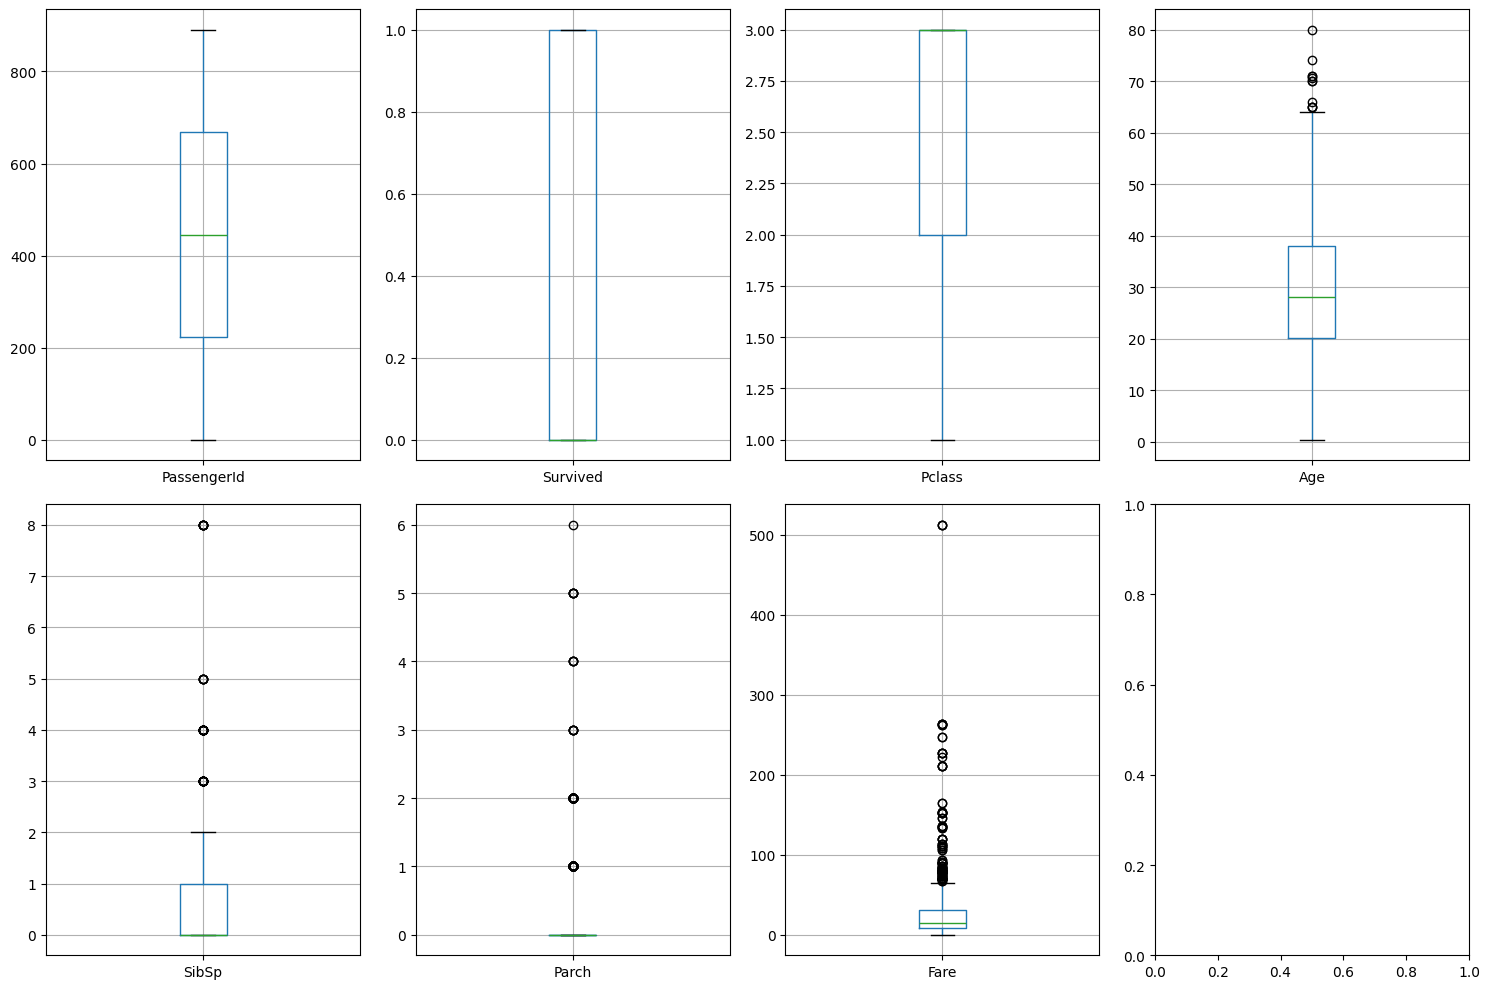

In [7]:
# Check for outliers in numerical features using subplots
cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
fig, axes = plt.subplots(2, 4, figsize = (15, 10))
axes = axes.flatten()

for i, cols in enumerate(cols):
    df.boxplot(column = cols, ax = axes[i])

plt.tight_layout()
plt.show()

In [8]:
# Remove outliers using IQR method

def remove_outliers(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    Lower_bound = Q1 - (1.5 * IQR)
    Upper_bound = Q3 + (1.5 * IQR)
    return Lower_bound, Upper_bound

cols = ['Age', 'SibSp', 'Parch', 'Fare']

for col in cols:
    lb, ub = remove_outliers(df[col])
    df[col] = np.where(df[col] < lb, lb, np.where(df[col] > ub, ub, df[col]))


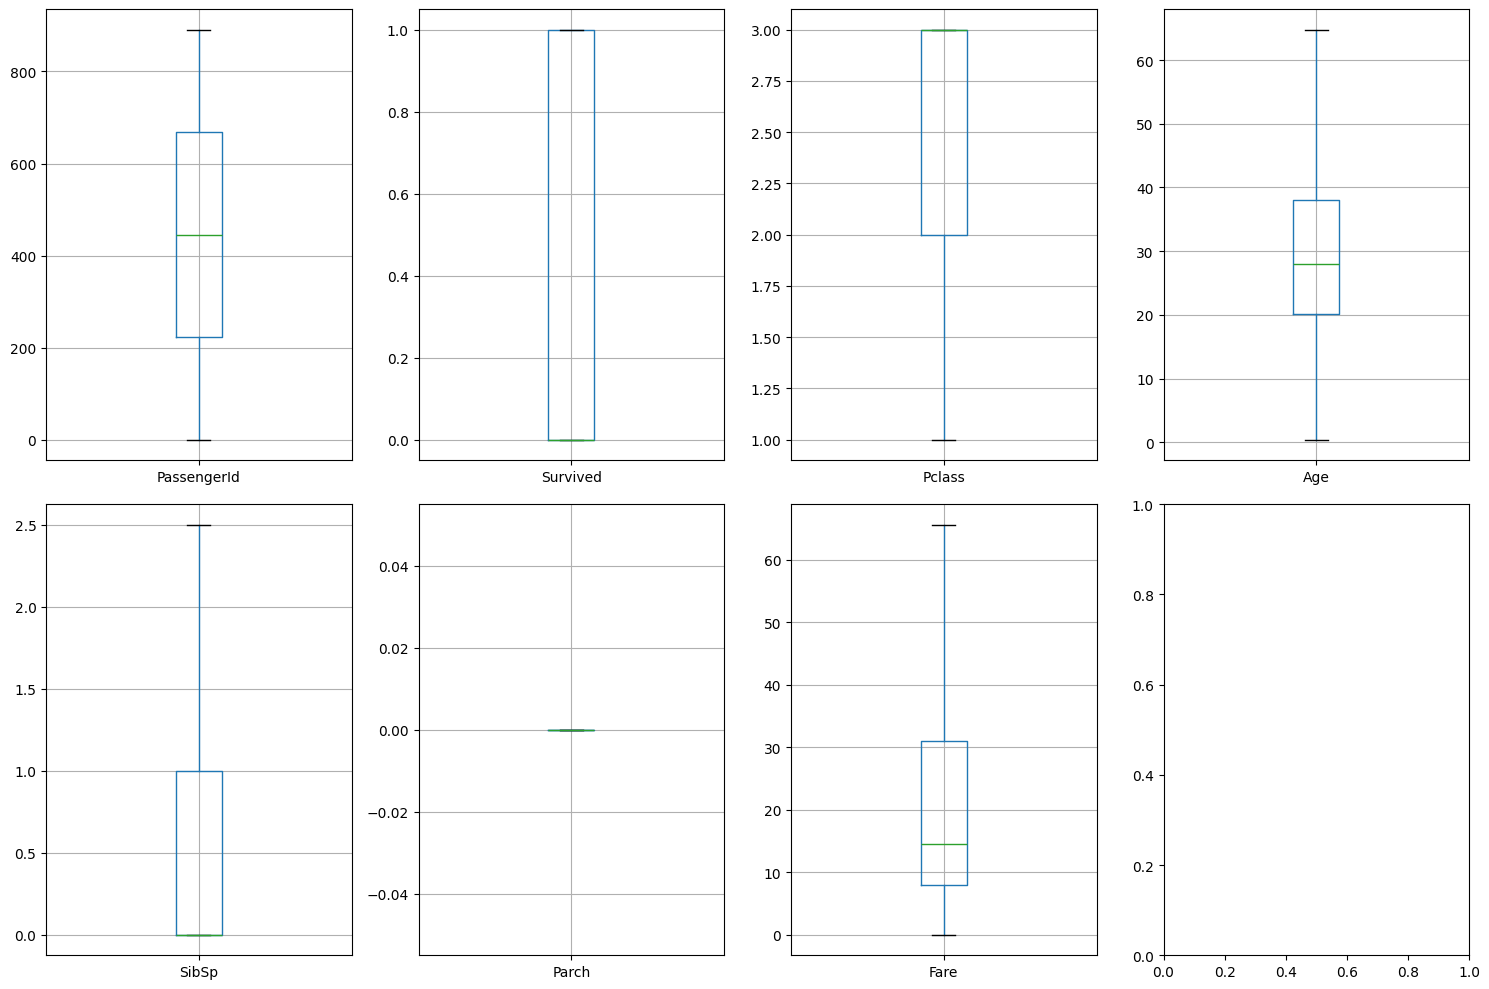

In [9]:
# Check if outliers are removed or not

cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

fig, axes = plt.subplots(2, 4, figsize = (15, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    df.boxplot(column = col, ax = axes[i])

plt.tight_layout()
plt.show()

In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
# Treat missing values

# Replacing null values in numerical columns with median
median_1 = df['Age'].median()
df['Age'] = df['Age'].replace(np.nan, median_1)

# Replacing null values in categorical columns with mode
mode_1 = df['Cabin'].mode()[0]
mode_2 = df['Embarked'].mode()[0]

df['Cabin'] = df['Cabin'].replace(np.nan, mode_1)
df['Embarked'] = df['Embarked'].replace(np.nan, mode_2)


In [12]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Univariate Analysis

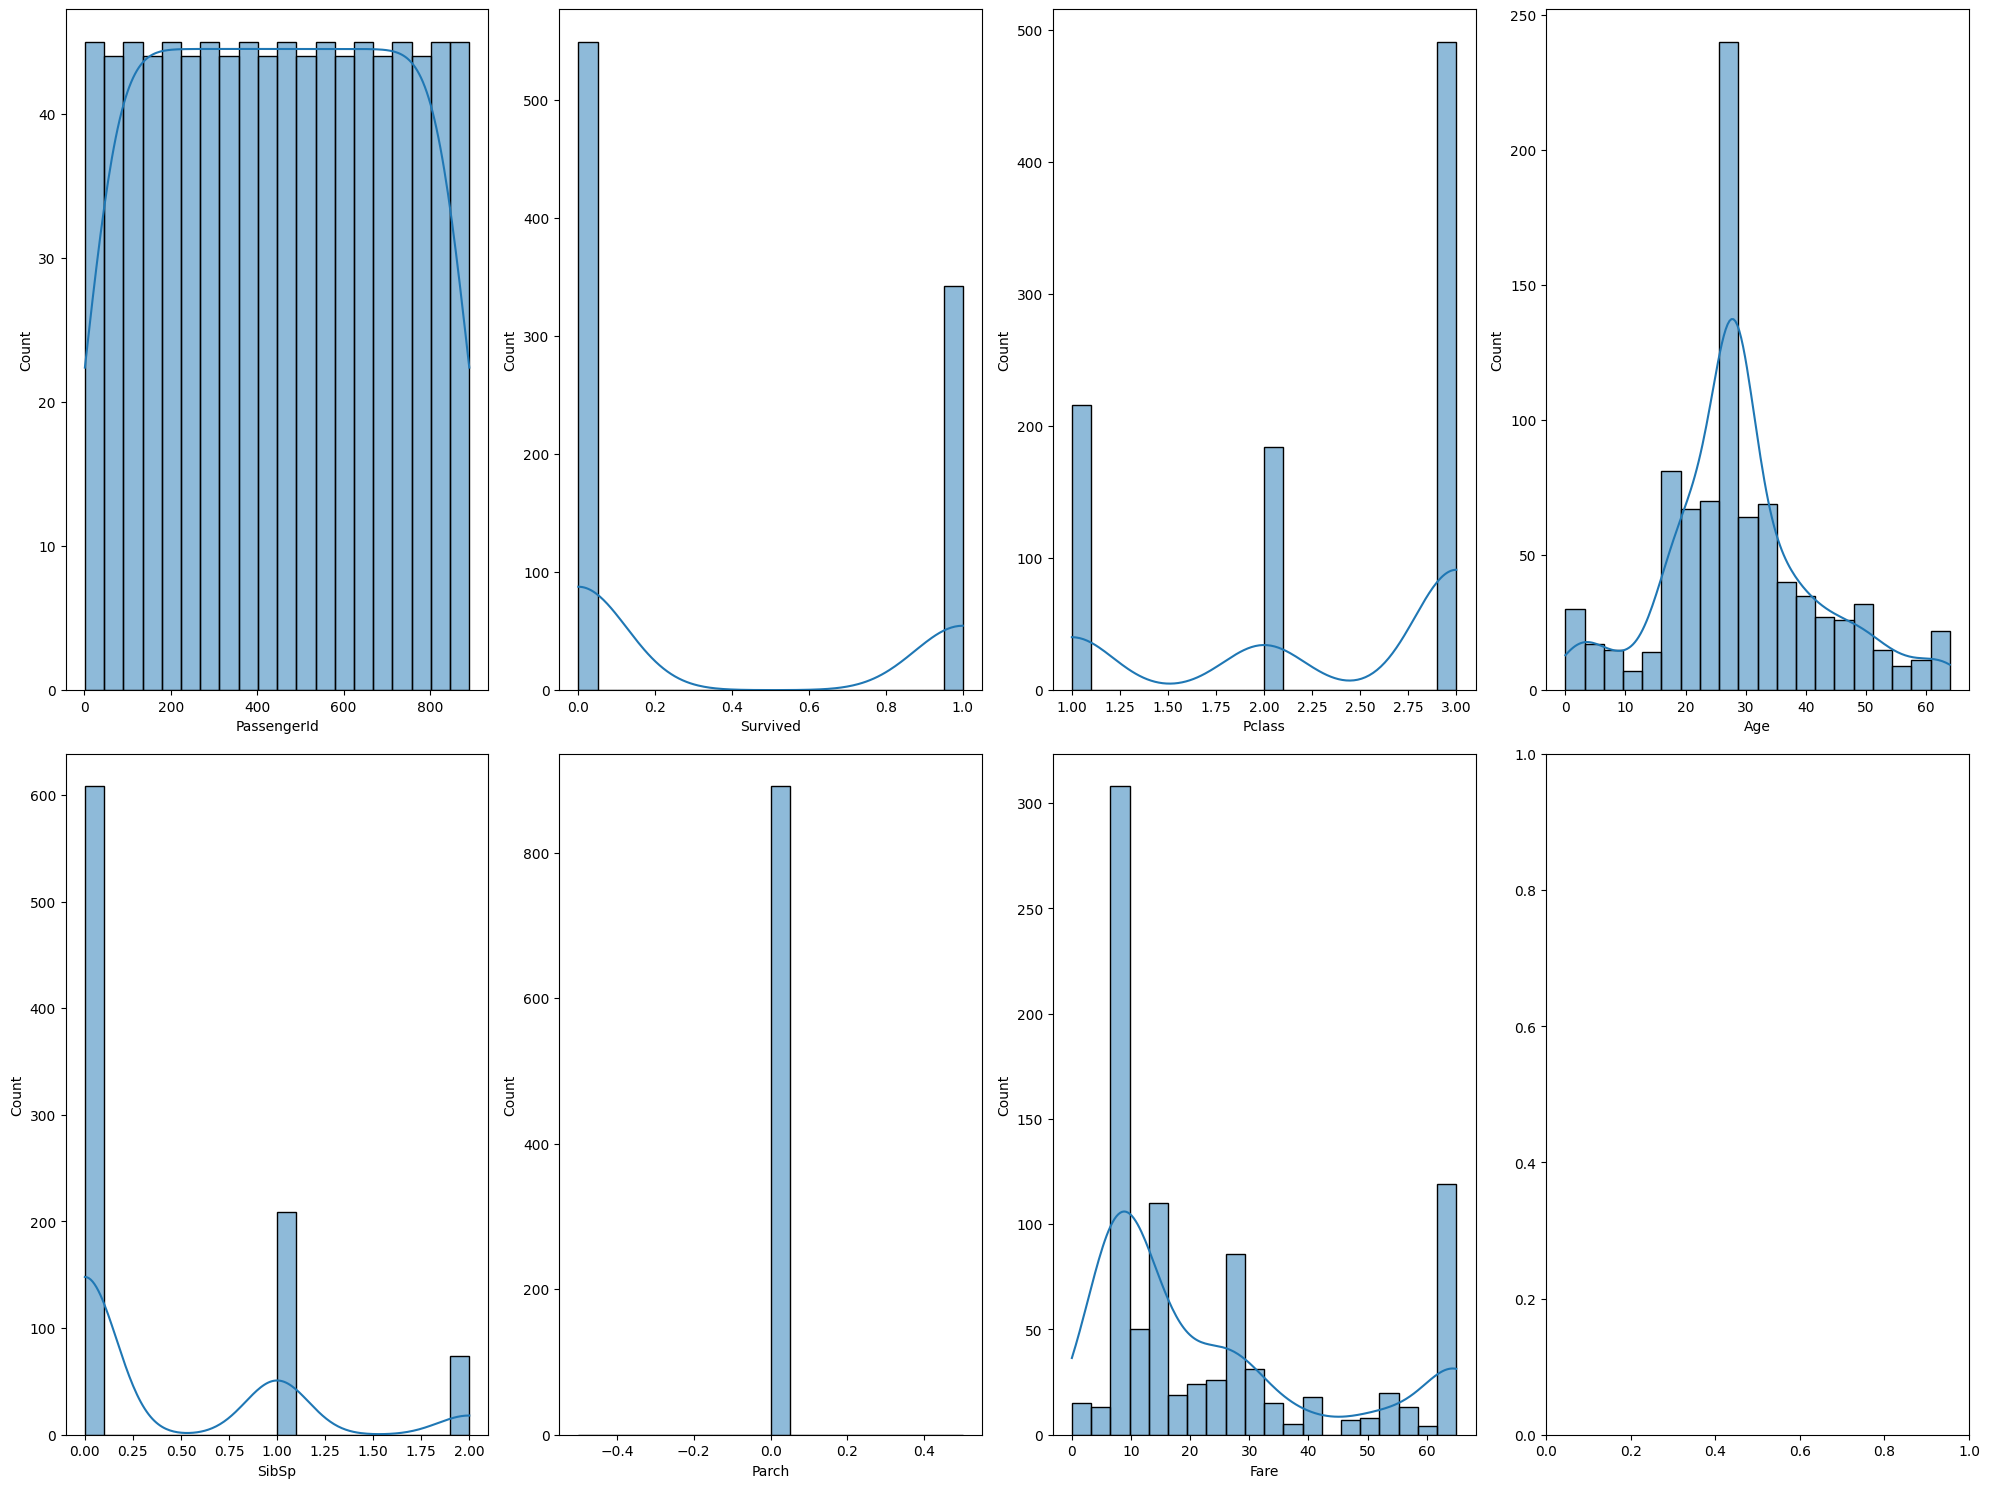

In [21]:
cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

fig, axes = plt.subplots(2, 4, figsize = (20, 15))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df[col], ax = axes[i], kde = True, bins = 20)

plt.tight_layout()
plt.show()

### Bivariate Analysis

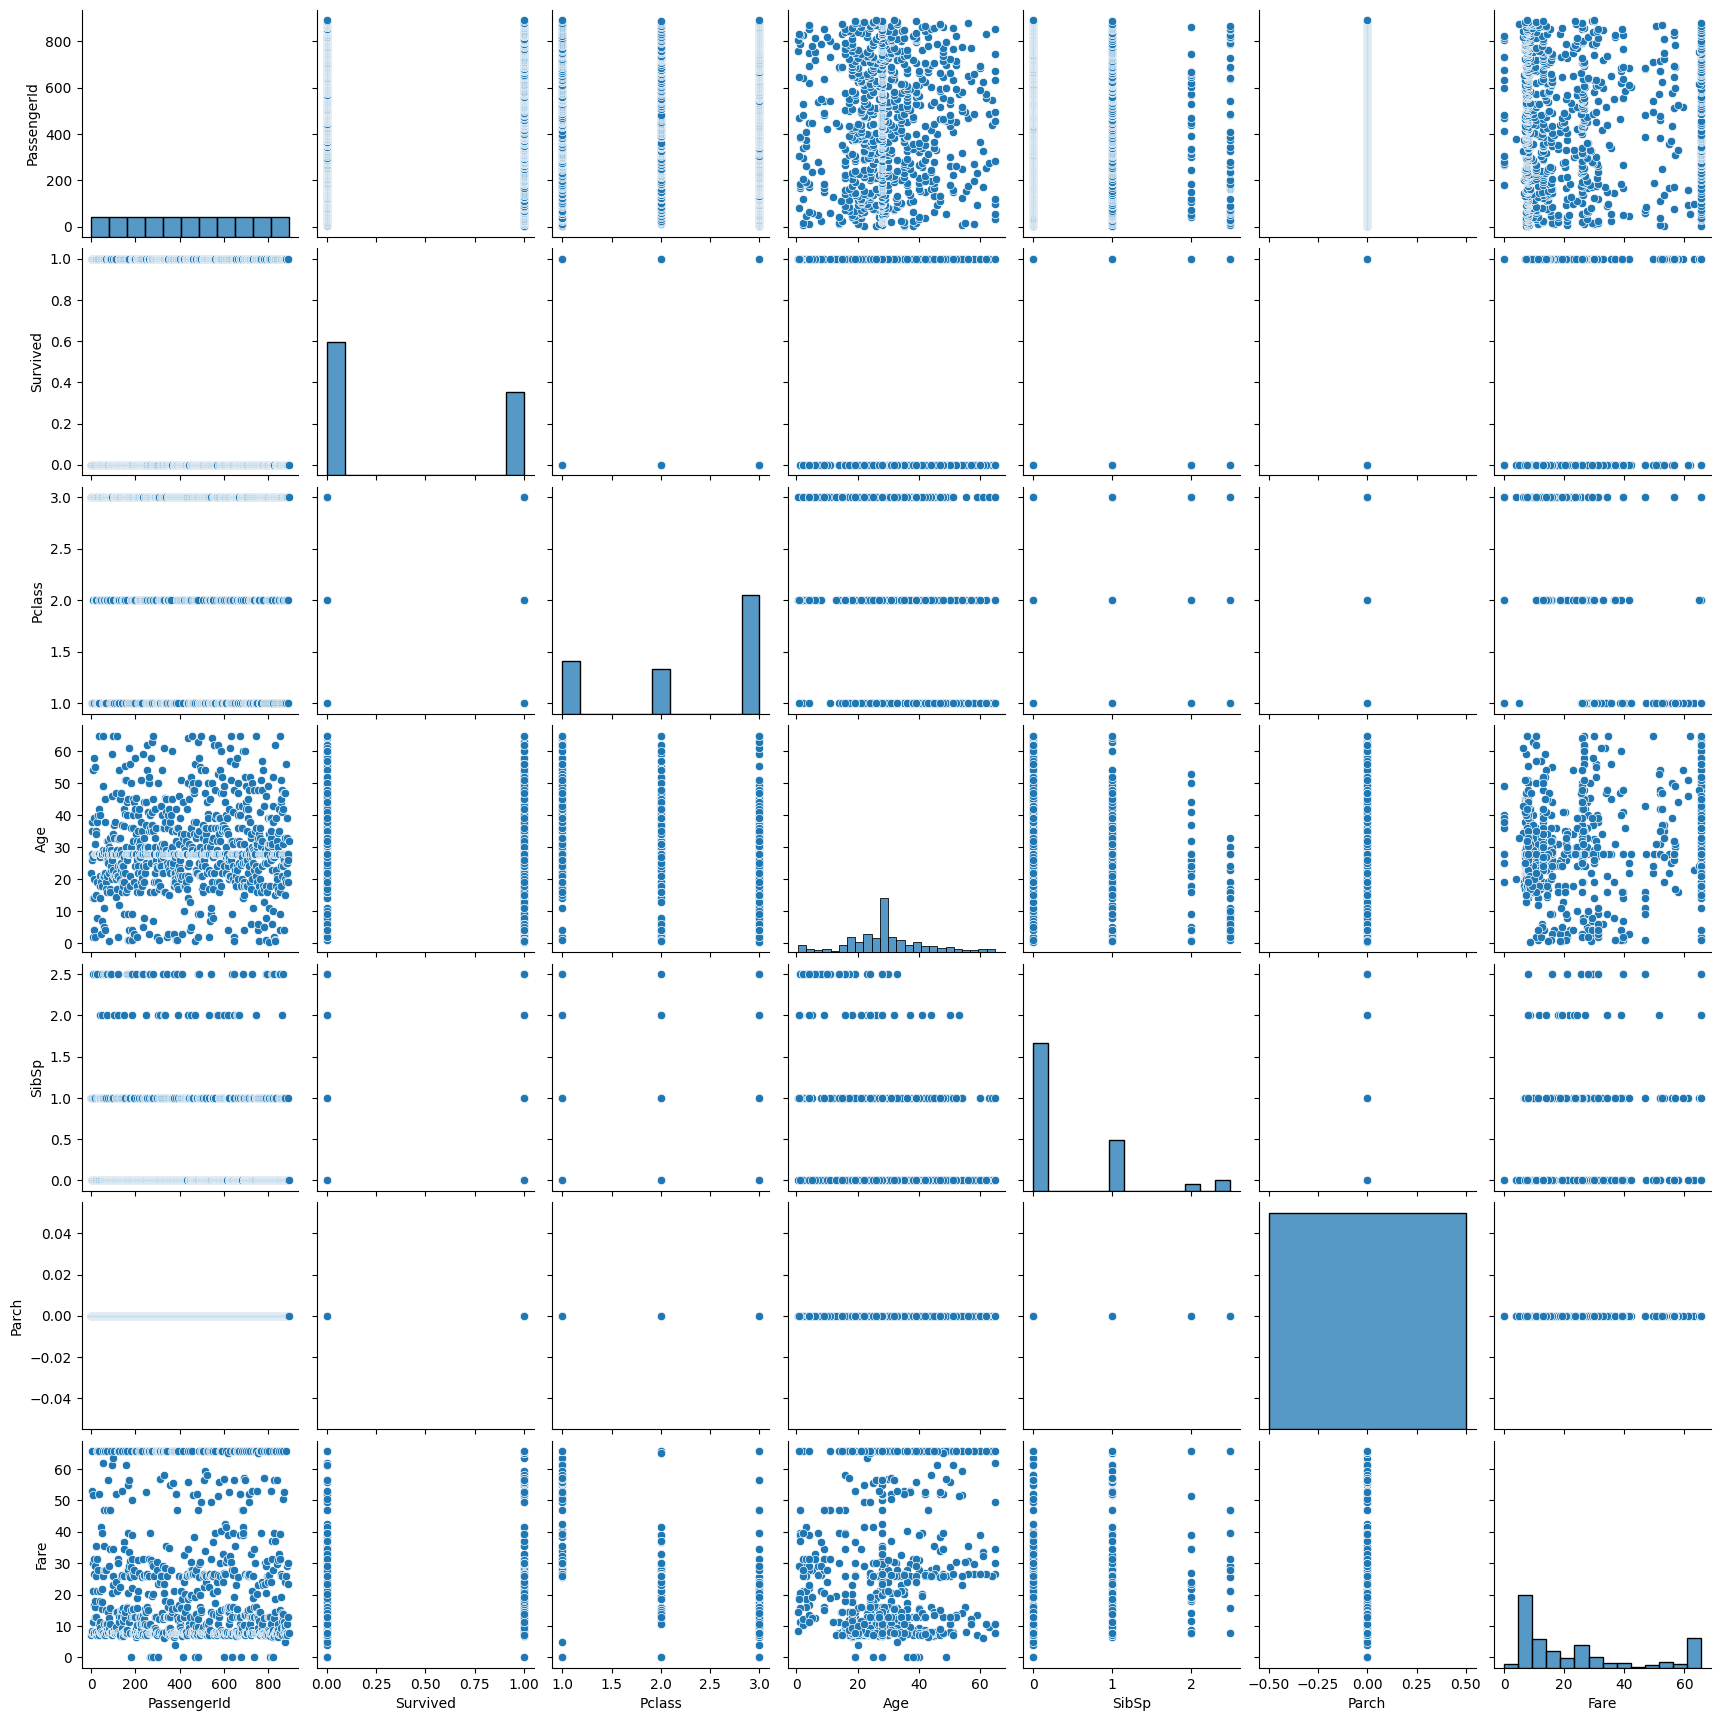

In [14]:
sns.pairplot(df)
plt.show()

### Multivariate Analysis

<Axes: >

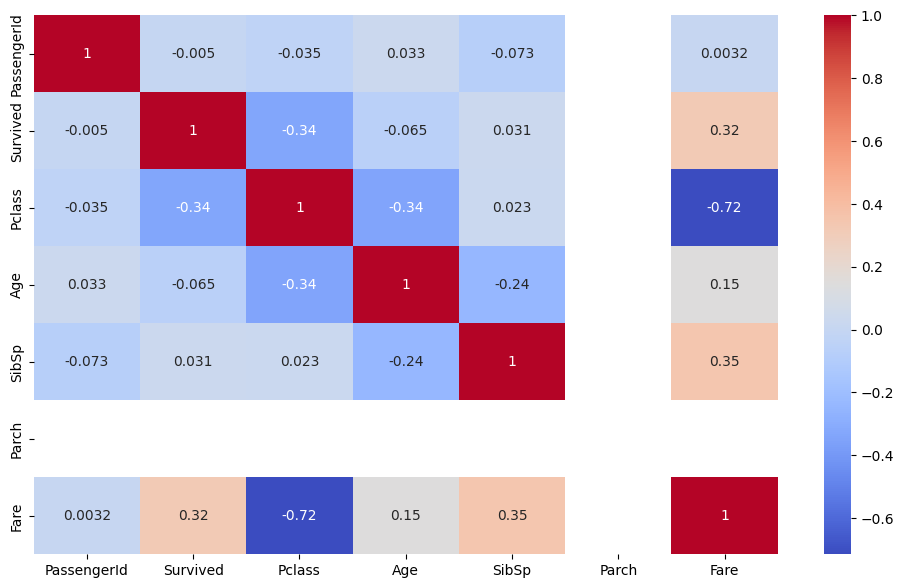

In [15]:
plt.figure(figsize = (12, 7))
sns.heatmap(df.select_dtypes(include = ['number']).corr(), annot = True, cmap = 'coolwarm')

In [16]:
# Converting categorical columns to numerical using one-hot encoding

categorical_cols = df.select_dtypes(include = 'object').columns
df = pd.get_dummies(df, columns = categorical_cols, drop_first = True).astype(int)

In [17]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel",...,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S
0,1,0,3,22,1,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,38,1,0,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,26,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,35,1,0,53,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,3,35,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Declare Feature variable and Target variable

In [18]:
X = df.drop('Survived', axis = 1)
Y = df['Survived']

### Split Data into training and testing

In [19]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [20]:
# Checking the shape of training and testing data

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((712, 1725), (179, 1725), (712,), (179,))

### XG Boost Classification

In [28]:
from xgboost import XGBRegressor
XGB_R = XGBRegressor()
XGB_R.fit(X_train, Y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [29]:
# Evaluating the model

from sklearn.metrics import mean_absolute_error

prediction = XGB_R.predict(X_test)
print("Mean Absolute Error: {}". format(prediction, Y_test))

Mean Absolute Error: [ 0.06851955  0.03239593  0.04253287  0.9743681   0.8598168   0.9580343
  0.84215343  0.04253287  0.8377807   0.94713426  0.18903884  0.03239593
  0.10366432  0.04811871  0.03239593  0.96299076  0.5339839   0.74451447
  0.10386794 -0.0257578   0.04253287  0.05053704  0.6580162   0.04253287
  0.03239593  0.04722564  0.05040327  0.03239593  0.0194155   0.39994803
  0.04253287  0.6608999   0.10193836  0.6623889   0.04253287  0.13758874
  0.3655433   0.84215343  0.9863484   0.03239593  0.03384116  0.03239593
  0.03239593  0.06851955  0.34860793  0.02165905  0.04541652  0.04253287
  0.04253287  0.5694817   0.90794235  0.9795456   0.02737866  0.6809868
  0.00678472  0.9751729   0.03527957  0.99526834  0.95524216  0.911169
  0.04253287  0.9793854   0.9502249   0.03468049  0.04811871  0.9365207
  0.03384116  0.03239593  0.05825567  1.0156692   0.94585216  0.9908956
  0.45800003  1.0156692   0.04253287  0.03239593  0.74451447  0.9787135
  0.95524216  0.44696668  0.03751561 